In [19]:
import pandas as pd
import numpy as np
import seaborn as sns

from tools_analysis import *

sns.set_theme()

In [20]:
folder_path = "../study"
stats_path = folder_path + "/stats"

In [31]:
# Reading the whole dataset
df = pd.read_csv("%s/dataset_thres1.csv" % stats_path, index_col="ID")
print(df.shape)
# # Removing the healty subjects
# df.dropna(axis=0, how="any", inplace=True) 
# print(df.shape)

info = df.columns[:10]
df[info] = df[info].astype(int)

df = df.drop("VNSLC_16") # remove it because doesn't have the tracts from freesurfer, if I comment it, all the TRACULA tracts will be removed
df = df.dropna(axis=1) # remove NaN features
df = df.drop(df.filter(regex=r'(min|max)'), axis=1) # remove max and min features because are full of imperfections
df = df.drop(df.filter(regex=r'(std|skew|kurt|nTracts)'), axis=1) # remove them beacuse they have an high variability and difficult to interpretare (only kurt)
df = df.loc[:, (abs(df - df.iloc[0]) > 1e-12).any()] # Removing almost constant features
print(df.shape)

X = df.drop(["resp", "respPart"], axis=1)
y = df["resp"]

(19, 7528)
(18, 1868)


# Logistic Regression

#### Scaling pruning

In [27]:
# Scaling pruning 

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [None, StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2"), RobustScaler()]:
    print(scaler.__class__.__name__)
    
    run_log_reg_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        penalty="l2"
        )

NoneType
F1: 0.084 | Pr: 0.671 | Re: 0.999 | AUC: 0.492 | Accuracy: 0.351 

StandardScaler
F1: 0.426 | Pr: 0.749 | Re: 0.964 | AUC: 0.669 | Accuracy: 0.506 

MinMaxScaler
F1: 0.405 | Pr: 0.773 | Re: 0.973 | AUC: 0.663 | Accuracy: 0.492 

Normalizer
F1: 0.704 | Pr: 0.743 | Re: 0.989 | AUC: 0.472 | Accuracy: 0.581 

Normalizer
F1: 0.704 | Pr: 0.740 | Re: 0.991 | AUC: 0.467 | Accuracy: 0.580 

RobustScaler
F1: 0.391 | Pr: 0.752 | Re: 0.971 | AUC: 0.636 | Accuracy: 0.473 



the best scaler is the standard scaler

#### Hyper parm pruning

In [ ]:
# Hyper-parameters pruning

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

param_grid = {
    "sgdclassifier__alpha" : [10e0, 5e1, 10e1, 5e2, 10e2, 5e3, 10e3, 5e4, 10e4]
}

pipe = make_pipeline(
    Normalizer("l1"), 
    SGDClassifier(loss = 'log_loss', n_jobs = -1, penalty = 'l2')
)

gridSearchF1 = GridSearchCV(
    pipe,
    param_grid,
    scoring="f1",
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearchF1.fit(X, y)

gridSearchAUC = GridSearchCV(
    pipe,
    param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearchAUC.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sgdclassifier',
                                        SGDClassifier(loss='log_loss',
                                                      n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'sgdclassifier__alpha': [10.0, 50.0, 100.0, 500.0,
                                                  1000.0, 5000.0, 10000.0,
                                                  50000.0, 100000.0]},
             scoring='roc_auc')

In [30]:
print("f1 score")
print(gridSearchF1.cv_results_["mean_test_score"])
print(gridSearchF1.cv_results_["std_test_score"])
print(gridSearchF1.cv_results_["rank_test_score"])
print("roc_auc score")
print(gridSearchAUC.cv_results_["mean_test_score"])
print(gridSearchAUC.cv_results_["std_test_score"])
print(gridSearchAUC.cv_results_["rank_test_score"])

f1 score
[0.68563175 0.70013095 0.69894365 0.61980238 0.55689127 0.4716
 0.4624     0.4728     0.456     ]
[0.20644831 0.20927321 0.22588747 0.3125589  0.35299328 0.39333629
 0.39510282 0.39331941 0.3960606 ]
[3 1 2 4 5 7 8 6 9]
roc_auc score
[0.70575  0.75725  0.775125 0.789375 0.790625 0.7935   0.79325  0.793375
 0.79425 ]
[0.20072852 0.21398876 0.21846764 0.22057365 0.22154906 0.22188454
 0.22333705 0.22194421 0.22138358]
[9 8 7 6 5 2 4 3 1]


[10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

A good trade-off could be 100

#### Scalar pruning with best hyperparameter

In [32]:
# Scaling pruning with best hyperparameter

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [None, StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2"), RobustScaler()]:
    print(scaler.__class__.__name__)
    
    run_log_reg_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        alpha=100,
        penalty="l2"
        )

NoneType
F1: 0.175 | Pr: 0.679 | Re: 0.999 | AUC: 0.487 | Accuracy: 0.382 

StandardScaler
F1: 0.778 | Pr: 0.874 | Re: 0.987 | AUC: 0.774 | Accuracy: 0.714 

MinMaxScaler
F1: 0.781 | Pr: 0.872 | Re: 0.992 | AUC: 0.770 | Accuracy: 0.715 

Normalizer
F1: 0.704 | Pr: 0.781 | Re: 0.961 | AUC: 0.561 | Accuracy: 0.596 

Normalizer
F1: 0.724 | Pr: 0.772 | Re: 0.991 | AUC: 0.575 | Accuracy: 0.616 

RobustScaler


#### Sequential Feature Selection

Here launch the feature selection in seqFeatureSelec.py with the tuned parameters.

Check the performance with the selected features

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

print("l2")
run_log_reg_cv(
        df[['epilepsy_type', 'epilepsy_duration', 'acomm_AD_mean', 'acomm_MD_mean', 'acomm_fbundle_mean', 'acomm_fextra_mean', 'acomm_fvf_tot_mean', 'acomm_icvf_mean', 'cc.bodyt_frac_csf_mf_mean', 'right-fornix_RD_mean']], 
        df["resp"],
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=StandardScaler(),
        alpha=100,
        penalty="l2"
        )

# Con l1 fa cagare

l2
F1: 0.857 | Pr: 1.000 | Re: 1.000 | AUC: 1.000 | Accuracy: 0.857 



SGDClassifier(alpha=100, loss='log_loss', n_jobs=-1)

#### Feature Weights

In [7]:
import eli5
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[['epilepsy_type', 'epilepsy_duration', 'acomm_AD_mean', 'acomm_MD_mean', 'acomm_fbundle_mean', 'acomm_fextra_mean', 'acomm_fvf_tot_mean', 'acomm_icvf_mean', 'cc.bodyt_frac_csf_mf_mean', 'right-fornix_RD_mean']],
    df["resp"],
    test_size=1/3,
    random_state=7,
    shuffle=True,
    stratify=df["resp"]
)

pipe = make_pipeline(
    StandardScaler(),
    SGDClassifier(loss = 'log_loss',
                         n_jobs = -1, 
                         penalty = 'l2', 
                         alpha=100,
                         max_iter=10000
    )
)

pipe.fit(X_train, y_train)

eli5.show_weights(pipe, feature_names=X_train.columns)

Weight?,Feature
+0.002,acomm_icvf_mean
+0.001,epilepsy_duration
+0.000,acomm_fvf_tot_mean
-0.001,acomm_fbundle_mean
-0.002,epilepsy_type
-0.002,acomm_fextra_mean
-0.003,acomm_MD_mean
-0.003,cc.bodyt_frac_csf_mf_mean
-0.003,acomm_AD_mean
-0.004,right-fornix_RD_mean


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


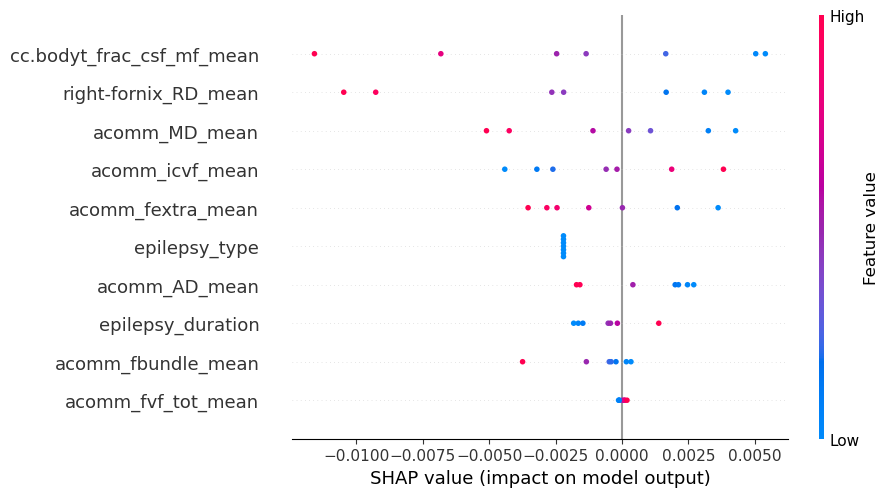

In [8]:
import shap
shap.initjs()
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    df[['epilepsy_type', 'epilepsy_duration', 'acomm_AD_mean', 'acomm_MD_mean', 'acomm_fbundle_mean', 'acomm_fextra_mean', 'acomm_fvf_tot_mean', 'acomm_icvf_mean', 'cc.bodyt_frac_csf_mf_mean', 'right-fornix_RD_mean']],
    df["resp"],
    test_size=1/3,
    random_state=7,
    shuffle=True,
    stratify=df["resp"]
)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

logReg = SGDClassifier(
    loss = 'log_loss',
    n_jobs = -1, 
    penalty = 'l2', 
    alpha=50,
    max_iter=10000
)

logReg.fit(X_train, y_train)

explainer = shap.Explainer(logReg, X_train, feature_names=df[['epilepsy_type', 'epilepsy_duration', 'acomm_AD_mean', 'acomm_MD_mean', 'acomm_fbundle_mean', 'acomm_fextra_mean', 'acomm_fvf_tot_mean', 'acomm_icvf_mean', 'cc.bodyt_frac_csf_mf_mean', 'right-fornix_RD_mean']].columns)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)#, X_test_array, feature_names=vectorizer.get_feature_names())

In [15]:
shap.plots.force(shap_values[0])

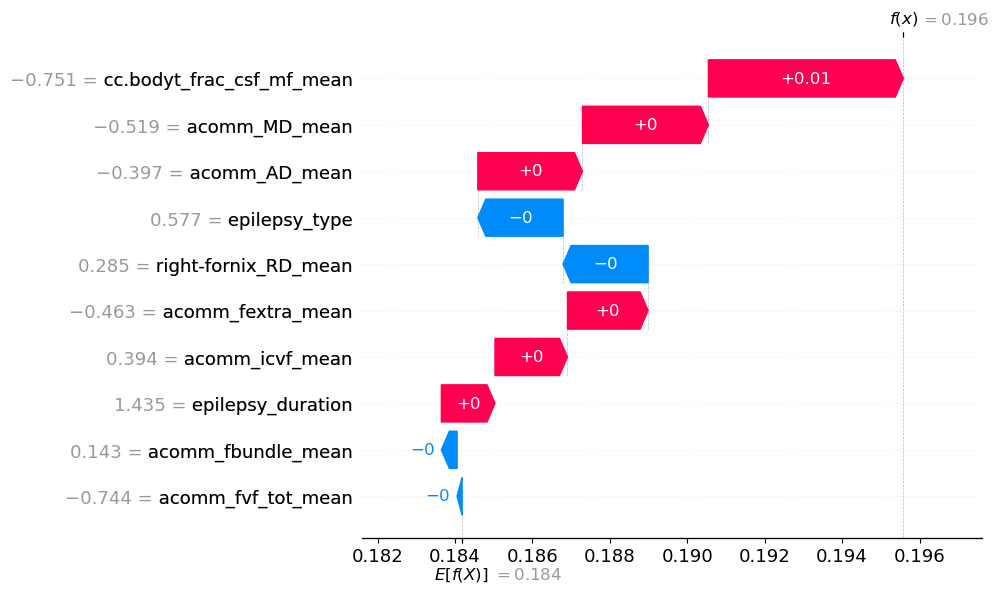

In [16]:
shap.plots.waterfall(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


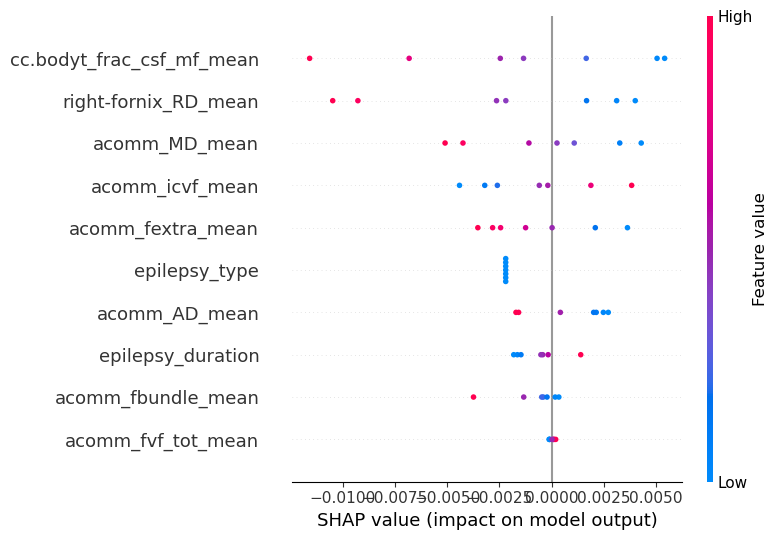

In [17]:
shap.summary_plot(shap_values, X_test)

KeyError: 'acomm_frac_csf_mf_std'

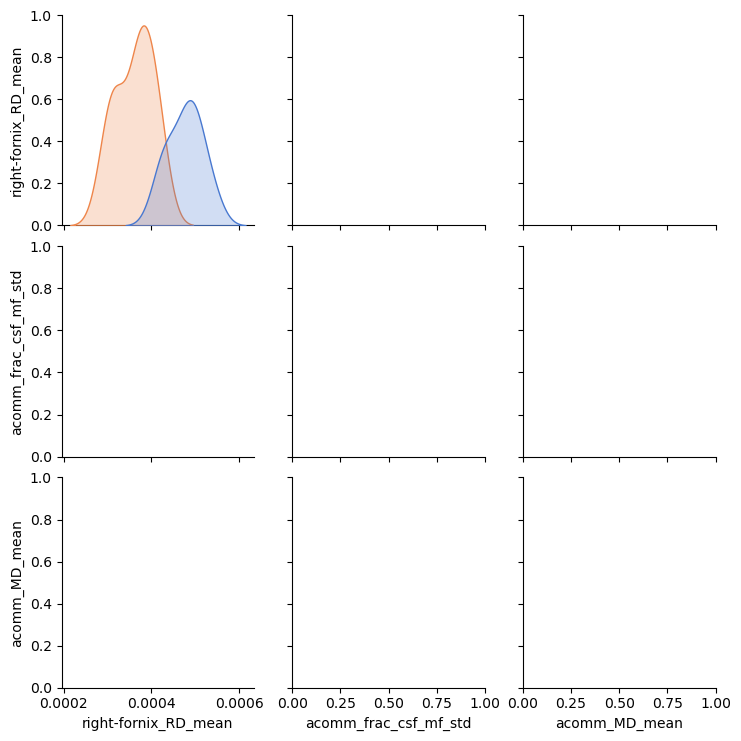

In [18]:
toPlot = ['acomm_icvf_mean', 'right-fornix_RD_mean', 'acomm_MD_mean']
ax = sns.pairplot(df, hue="resp", x_vars=toPlot, y_vars=toPlot)

# SVM

In [10]:
from pandas import DataFrame
from sklearn.linear_model import SGDClassifier

In [9]:
def calc_f1(p_and_r):
    p, r = p_and_r
    if p == 0 and r == 0:
        return 0
    return (2*p*r)/(p+r)


# Print the F1, Precision, Recall, ROC-AUC, and Accuracy Metrics 
# Since we are optimizing for F1 score - we will first calculate precision and recall and 
# then find the probability threshold value that gives us the best F1 score

def print_model_metrics(y_test, y_test_prob, confusion = False, verbose = True, return_metrics = False):

    precision, recall, threshold = precision_recall_curve(y_test, y_test_prob, pos_label = 1)

    #Find the threshold value that gives the best F1 Score
    best_f1_index =np.argmax([calc_f1(p_r) for p_r in zip(precision, recall)])
    best_threshold, best_precision, best_recall = threshold[best_f1_index], precision[best_f1_index], recall[best_f1_index]
    
    # Calulcate predictions based on the threshold value
    y_test_pred = np.where(y_test_prob > best_threshold, 1, 0)
    
    # Calculate all metrics
    if np.unique(y_test).size > 2:
        averageF1 = "weighted"
    else:
        averageF1 = "binary"
    f1 = f1_score(y_test, y_test_pred, pos_label = 1, average = averageF1)
    roc_auc = roc_auc_score(y_test, y_test_prob, multi_class="ovo")
    acc = accuracy_score(y_test, y_test_pred)
    
    
    if confusion:
        # Calculate and Display the confusion Matrix
        cm = confusion_matrix(y_test, y_test_pred)

        plt.title('Confusion Matrix')
        sns.set(font_scale=1.0) #for label size
        sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = ['No Clickbait', 'Clickbait'], yticklabels = ['No Clickbait', 'Clickbait'], annot_kws={"size": 14}, cmap = 'Blues')# font size

        plt.xlabel('Truth')
        plt.ylabel('Prediction')
        
    if verbose:
        print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(f1, best_precision, best_recall, roc_auc, acc))
    
    if return_metrics:
        return np.array([f1, best_precision, best_recall, roc_auc, acc])

In [12]:
def run_svm_cv(features: DataFrame, y: DataFrame, cv, pipeline=None, alpha = 1e-4, penalty="l2", confusion = False, return_f1 = False, verbose = True):
    metrics = np.zeros(5)
    features = features.to_numpy()
    y = y.to_numpy()
    for train, test in cv.split(features, y):
        train_features, test_features = features[train, :], features[test, :]
        y_train, y_test = y[train], y[test]

        if pipeline is not None:
            pipeline.fit(train_features)
            train_features = pipeline.transform(train_features)
            test_features = pipeline.transform(test_features)

        svm = SGDClassifier(loss = 'hinge', alpha = alpha, n_jobs = -1, penalty = penalty)
        svm.fit(train_features, y_train)

        y_test_prob = svm.predict_proba(test_features)[:,1]
        metrics += print_model_metrics(y_test, y_test_prob, confusion = confusion, verbose = False, return_metrics = True)

    metrics /=cv.get_n_splits()
    if verbose:
        print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(*metrics))
    if return_f1:
        return metrics[0]
    return svm

In [13]:
# Scaling pruning 

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [None, StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2"), RobustScaler()]:
    print(scaler.__class__.__name__)
    
    run_svm_cv(
        df, 
        df["resp"],
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        penalty="l2"
        )

NoneType


AttributeError: probability estimates are not available for loss='hinge'